<center><img src="images/header.png"></center>

<h1><center>Алгоритмы интеллектуальной обработки больших объемов данных</center></h1>
<hr>
<h2><center>Деревья решений, случайные леса (практика)</center></h2>

**Срок сдачи:** 3 апреля 2017, 06:00 <br> 
**Штраф за опоздание:** -2 балла после 06:00 3 апреля, -4 балла после 06:00 10 апреля, -6 баллов после 06:00 17 апреля

При отправлении ДЗ указывайте фамилию в названии файла<br>

Не забудте создать задание в Slack через /todo.

Используйте данный Ipython Notebook при оформлении домашнего задания.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,8)

# Для кириллицы на графиках
font = {'family': 'Verdana',
        'weight': 'normal'}
plt.rc('font', **font)

In [2]:
from tqdm import tqdm_notebook

for i in tqdm_notebook(xrange(1000000)):
    pass

# Практика

### Качество вина (10 баллов)

Давайте все-таки разберемся с [вином](https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv)!


#### Задание (1 балл)
* Загрузите данные, выполните преобразование целевой переменной: 
    * quality > 5 -> 1
    * quality <= 5 -> 0
* Разделите выборку на обучающую и контрольную в пропорции 80/20

In [3]:
df = pd.read_csv('winequality-red.csv', sep=';')
#df.loc[:, 'quality'] = (df.loc[:, 'quality'] > 5).astype(int)
df.quality = (df.quality > 5).astype(int)
df.quality.value_counts()

1    855
0    744
Name: quality, dtype: int64

In [4]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,1
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0


In [5]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size=0.2)
print len(df), len(df_train), len(df_test)

1599 1279 320


#### Задание (2 балла)

Сфокусируемся на одном гиперпараметре деревьев решений - максимальной глубине.

Подберите наилучшую глубину `d` дерева с помошью 
* Усредненной оценки качества roc-auc на кросс-валидации при различных `d`
* Валидационных кривых

In [6]:
from sklearn.tree import DecisionTreeClassifier

try:
    from sklearn.model_selection import cross_val_score
except ImportError:
    from sklearn.cross_validation import cross_val_score

try:
    from sklearn.model_selection import validation_curve
except ImportError:
    from sklearn.learning_curve import validation_curve

/home/ivan/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family [u'Verdana'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


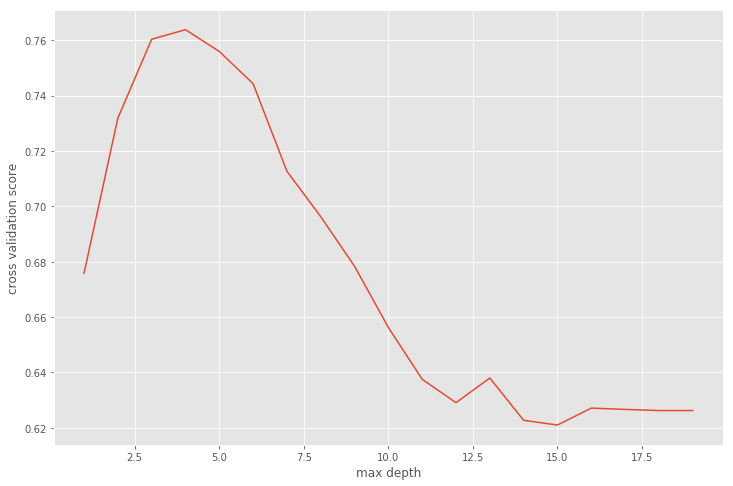

In [7]:
val = []

for i in xrange(1,20):
    tree = DecisionTreeClassifier(max_depth=i, random_state=1)
    scores = cross_val_score(tree, X=df.iloc[:,0:-1], y=df.iloc[:,-1], cv=5, scoring='roc_auc')
    val.append(scores.mean())
    
plt.plot(xrange(1,20), val)
plt.ylabel('cross validation score')
plt.xlabel('max depth')

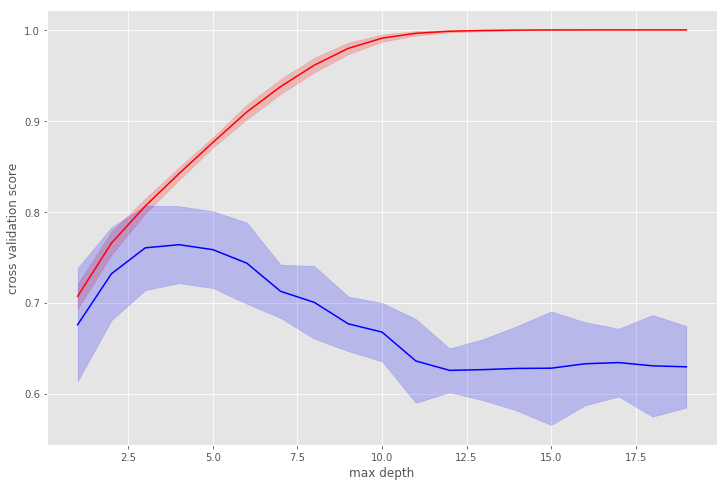

In [8]:
tree = DecisionTreeClassifier()
train_scores, test_scores = validation_curve(tree, X=df.iloc[:,0:-1], 
                                             y=df.iloc[:,-1], param_name='max_depth', 
                                             param_range=range(1,20), cv=5, scoring='roc_auc')

train_mean = train_scores.mean(axis=1)
test_mean = test_scores.mean(axis=1)
train_std = train_scores.std(axis=1)
test_std = test_scores.std(axis=1)

X = xrange(1,20)
plt.plot(X, train_mean, color='r')
plt.fill_between(X, train_mean+train_std, train_mean-train_std ,color='r', alpha=0.2)
plt.plot(X, test_mean, color='b')
plt.fill_between(X, test_mean+test_std, test_mean-test_std ,color='b', alpha=0.2)

plt.ylabel('cross validation score')
plt.xlabel('max depth')

Метрика : оптимальный параметр<br>
<br>
roc_auc   : 4<br>
accuracy  : 5<br>
precision : 4<br>
recall    : 5<br>
F1        : 5<br>
<br>
Большинством голосов получается, что оптимальная глубина дерева равна 5. Переобучение еще не сильное, а на тестовой выборке качество классификации максимальное.

#### Задание (1 балл)

Отсортируйте признаки по важности. Вектор с важностью признаков можно получить с помощью `model.feature_importances_`

In [9]:
model = DecisionTreeClassifier(max_depth=5, random_state=1)
model.fit(X=df.iloc[:,0:-1], y=df.iloc[:,-1])
indices = np.argsort(model.feature_importances_)
sorted_features = df.columns[indices]
print 'Вектор важности:\n', model.feature_importances_
print '\nСписок признаков:\n', df.columns
print '\nОтсортированные по важности признаки (самые важные - в конце):\n', sorted_features

Вектор важности:
[ 0.06655055  0.08313722  0.00983134  0.00559642  0.01148551  0.01455628
  0.11612107  0.          0.02907788  0.18826979  0.47537394]

Список признаков:
Index([u'fixed acidity', u'volatile acidity', u'citric acid',
       u'residual sugar', u'chlorides', u'free sulfur dioxide',
       u'total sulfur dioxide', u'density', u'pH', u'sulphates', u'alcohol',
       u'quality'],
      dtype='object')

Отсортированные по важности признаки (самые важные - в конце):
Index([u'density', u'residual sugar', u'citric acid', u'chlorides',
       u'free sulfur dioxide', u'pH', u'fixed acidity', u'volatile acidity',
       u'total sulfur dioxide', u'sulphates', u'alcohol'],
      dtype='object')


#### Задание (2 балла)
* Получите предсказания на тестовой выборке
* Постройте ROC кривые для обучающей и тестовой выборок
* Посчитайте остальные меры качества классификации при пороге в `0.5`

In [11]:
#обучаем на обучающей выборке
model = DecisionTreeClassifier(max_depth=5, random_state=1)
model.fit(df_train.iloc[:,0:-1], df_train.iloc[:,-1])

#вероятности классов
labels_train = model.predict_proba(df_train.iloc[:,0:-1])
labels_test = model.predict_proba(df_test.iloc[:,0:-1])

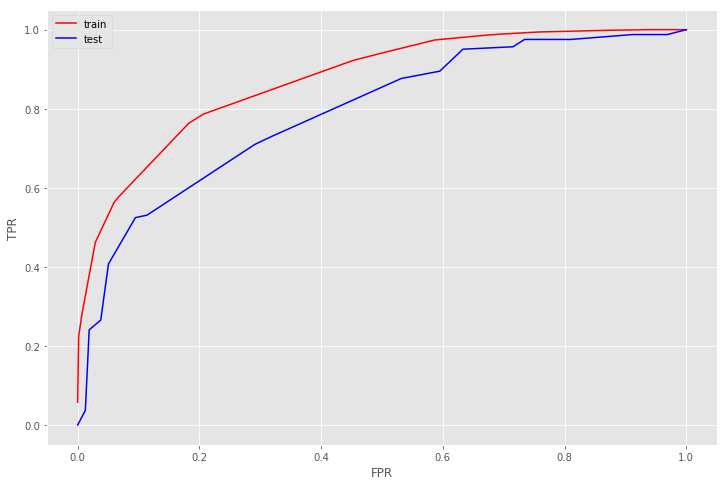

In [12]:
from sklearn.metrics import roc_curve

fpr_train, tpr_train, thresholds_train = roc_curve(df_train.iloc[:,-1], labels_train[:,1])
fpr_test, tpr_test, thresholds_test = roc_curve(df_test.iloc[:,-1], labels_test[:,1])
 
plt.plot(fpr_train, tpr_train, color='r', label='train')
plt.plot(fpr_test, tpr_test, color='b', label='test')
plt.legend()
plt.xlabel('FPR')
plt.ylabel('TPR')

Видно, что ROC-кривая для обучающей выборки получше, чем для тестовой - небольшое переобучение.

Бинаризуем массив вероятностей классов на тестовой выборке с порогом 0,5:

In [13]:
from sklearn.preprocessing import Binarizer

bnr = Binarizer(threshold=0.5)
test_classes = labels_test[:,1].reshape(1, -1)
true_classes = df_test.iloc[:,-1].values.reshape(1, -1)
scores_test = bnr.fit_transform(test_classes).astype(int)
print scores_test

[[1 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 1 1 1 0 0 1 1 1 0 0 0 1 1 1 0 1 0 1 0 0 1
  1 1 0 1 0 0 0 0 1 1 1 0 1 0 1 1 0 1 1 0 0 0 1 1 1 0 0 0 0 1 1 1 0 0 1 1 0
  1 1 1 1 0 1 0 1 1 1 1 1 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 1 0 1 1 1 1 1 0 1 1
  0 1 1 1 1 1 1 0 1 0 1 0 0 0 1 1 0 1 1 0 0 1 1 1 0 1 1 1 1 1 0 1 1 1 1 0 1
  0 1 1 1 1 0 0 0 1 1 1 1 1 0 0 0 1 0 1 1 1 1 0 0 0 0 0 1 0 0 0 1 0 1 1 1 1
  1 0 0 0 1 0 0 0 1 0 1 0 0 0 0 1 1 0 1 1 1 1 0 1 1 0 1 0 0 1 0 0 0 0 1 1 1
  1 1 0 0 0 0 1 0 1 1 1 1 1 1 1 1 0 1 1 0 0 1 1 1 1 0 0 0 1 0 0 1 0 1 1 1 0
  0 1 0 1 1 1 0 1 0 1 0 1 1 1 0 0 1 0 0 1 0 0 0 1 0 0 1 1 1 1 0 0 1 0 1 1 0
  1 0 1 0 1 0 0 1 0 0 1 0 0 0 0 1 1 0 1 0 1 0 1 0]]


Метрики качества при пороге 0,5 на тестовой выборке:

In [14]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

print 'Accuracy = ', accuracy_score(true_classes[0], scores_test[0])
print 'Precision = ', precision_score(true_classes[0], scores_test[0])
print 'Recall = ', recall_score(true_classes[0], scores_test[0])
print 'F1 = ', f1_score(true_classes[0], scores_test[0])
print 'ROC auc = ', roc_auc_score(true_classes[0], labels_test[:,1])

Accuracy =  0.70625
Precision =  0.702380952381
Recall =  0.728395061728
F1 =  0.715151515152
ROC auc =  0.790768088764


Все метрики дают значение меньше 0,8, а некоторые даже 0,7 - не очень хороший результат на тестовой выборке.

#### Задание (1 балл)
Перейдем к модели случайного леса. Зафиксируем некоторую глубину дерева (можно взять оптимальное с предыдущих заданий).

Сравните качество работы 
* Простого дерева решений
* Бэггинга над 10,20,...,100 деревьями решений
* Случайного леса с 10,20,...,100 деревьями решений

Получите график, у которого по оси X откладывается количество деревьев, а по оси Y - качество классификации.

In [15]:
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier

In [16]:
#Bagging
tree = DecisionTreeClassifier(max_depth=5, random_state=1)
bagging = BaggingClassifier(base_estimator=tree)

train_scores_bagging, test_scores_bagging = validation_curve(bagging, X=df.iloc[:,0:-1], 
                                             y=df.iloc[:,-1], param_name='n_estimators', 
                                             param_range=range(1,100,2), cv=5, scoring='roc_auc')

In [17]:
#Random forest
forest = RandomForestClassifier(max_depth=5, random_state=1)

train_scores_forest, test_scores_forest = validation_curve(forest, X=df.iloc[:,0:-1], 
                                             y=df.iloc[:,-1], param_name='n_estimators', 
                                             param_range=range(1,100,2), cv=5, scoring='roc_auc')

In [18]:
#Приведение данных
train_std_bagging = train_scores_bagging.std(axis=1)
test_std_bagging = test_scores_bagging.std(axis=1)

train_std_forest = train_scores_forest.std(axis=1)
test_std_forest = test_scores_forest.std(axis=1)

train_mean_bagging = train_scores_bagging.mean(axis=1)
test_mean_bagging = test_scores_bagging.mean(axis=1)

train_mean_forest = train_scores_forest.mean(axis=1)
test_mean_forest = test_scores_forest.mean(axis=1)

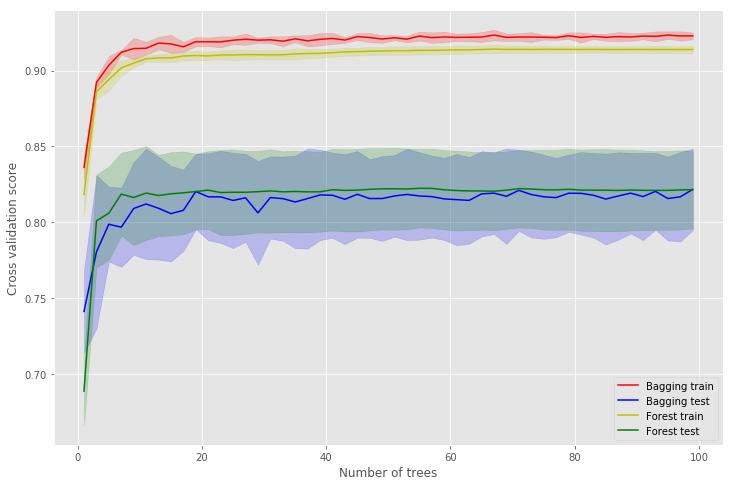

In [19]:
plt.plot(xrange(1,100,2), train_mean_bagging, color='r', label='Bagging train')
plt.plot(xrange(1,100,2), test_mean_bagging, color='b', label='Bagging test')
plt.plot(xrange(1,100,2), train_mean_forest, color='y', label='Forest train')
plt.plot(xrange(1,100,2), test_mean_forest, color='g', label='Forest test')

plt.fill_between(xrange(1,100,2), train_mean_bagging-train_std_bagging, train_mean_bagging+train_std_bagging,
                 alpha=0.2, color='r')
plt.fill_between(xrange(1,100,2), test_mean_bagging-test_std_bagging, test_mean_bagging+test_std_bagging,
                 alpha=0.2, color='b')
plt.fill_between(xrange(1,100,2), train_mean_forest-train_std_forest, train_mean_forest+train_std_forest,
                 alpha=0.2, color='y')
plt.fill_between(xrange(1,100,2), test_mean_forest-test_std_forest, test_mean_forest+test_std_forest,
                 alpha=0.2, color='g')
plt.legend()
plt.xlabel('Number of trees')
plt.ylabel('Cross validation score')

Случайные леса лучше, чем бэггинг - меньше переобучение и лучше качество на тестовой выборке. Для получения хорошего качества классификации достаточно 10 деревьев, дальше рост качества практически не наблюдается.

Сравним дерево с глубиной 5 с лесом из 10 деревьев той же глубины по метрике ROC auc:

In [20]:
tree = DecisionTreeClassifier(max_depth=5, random_state=1)
bagging = BaggingClassifier(base_estimator=tree, n_estimators=10)
forest = RandomForestClassifier(max_depth=5, random_state=1, n_estimators=10)

for metric in ('roc_auc', 'accuracy', 'precision', 'recall', 'f1'):
    print metric
    print 'Tree: ', cross_val_score(tree, X=df_train.iloc[:,0:-1], y=df_train.iloc[:,-1],
                    cv=5, scoring=metric).mean()
    print 'Bagging: ', cross_val_score(bagging, X=df_train.iloc[:,0:-1], y=df_train.iloc[:,-1],
                    cv=5, scoring=metric).mean()
    print 'Forest: ', cross_val_score(forest, X=df_train.iloc[:,0:-1], y=df_train.iloc[:,-1],
                    cv=5, scoring=metric).mean()
    print '\n'

roc_auc
Tree:  0.770961702758
Bagging:  0.834457059185
Forest:  0.831115065244


accuracy
Tree:  0.73100950351
Bagging:  0.748956998169
Forest:  0.756003757534


precision
Tree:  0.757202635421
Bagging:  0.767705939893
Forest:  0.766197031929


recall
Tree:  0.741643207173
Bagging:  0.78345323741
Forest:  0.793608591388


f1
Tree:  0.748830475472
Bagging:  0.780801519039
Forest:  0.778493671232




Лес и бэггинг дает лучший результат по всем метрикам, чем одно дерево. Кроме того, это хорошо видно на графике выше - левый край, который соответствует лесу из одного дерева, сильно меньше остальных точек.<br>
Друг от друга лес и бэггинг отличаются не так сильно, хотя в среднем для леса метрики выше.

Построим ROC-кривую для одного дерева, бэггинга и леса деревьев:

In [21]:
from sklearn.metrics import roc_curve

#Классификаторы для сравнения
tree = DecisionTreeClassifier(max_depth=5, random_state=1)
bagging = BaggingClassifier(base_estimator=tree, n_estimators=20)
forest = RandomForestClassifier(max_depth=5, random_state=1, n_estimators=20)

#Обучаем на обучающей выборке
tree.fit(X=df_train.iloc[:,0:-1], y=df_train.iloc[:,-1])
bagging.fit(X=df_train.iloc[:,0:-1], y=df_train.iloc[:,-1])
forest.fit(X=df_train.iloc[:,0:-1], y=df_train.iloc[:,-1])

#Считаем вектора вероятностей классов на тестовой выборке
labels_test_tree = tree.predict_proba(df_test.iloc[:,0:-1])
labels_test_bagging = bagging.predict_proba(df_test.iloc[:,0:-1])
labels_test_forest = forest.predict_proba(df_test.iloc[:,0:-1])

#Находим TPR и FPR на тестовой выборке
fpr_test_tree, tpr_test_tree, thresholds_test_tree = roc_curve(df_test.iloc[:,-1], labels_test_tree[:,1])
fpr_test_bagging, tpr_test_bagging, thresholds_test_bagging = roc_curve(df_test.iloc[:,-1], labels_test_bagging[:,1])
fpr_test_forest, tpr_test_forest, thresholds_test_forest = roc_curve(df_test.iloc[:,-1], labels_test_forest[:,1])

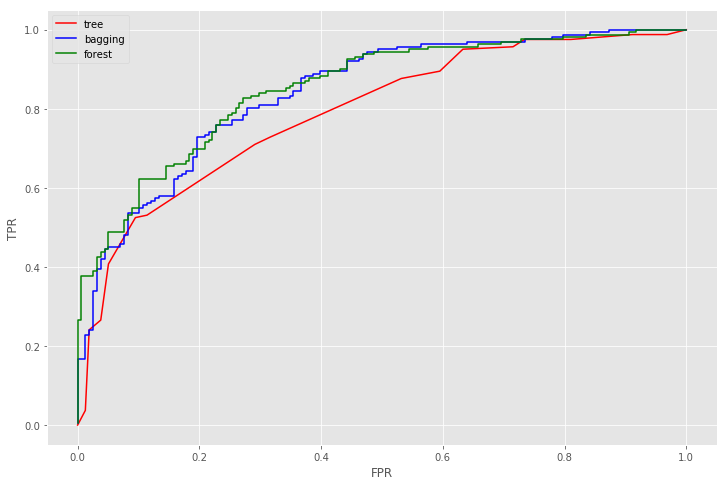

In [22]:
plt.plot(fpr_test_tree, tpr_test_tree, color='r', label='tree')
plt.plot(fpr_test_bagging, tpr_test_bagging, color='b', label='bagging')
plt.plot(fpr_test_forest, tpr_test_forest, color='g', label='forest')
plt.legend()
plt.xlabel('FPR')
plt.ylabel('TPR')

У коллективных методов (бэггинг и лес) ROC-кривая лучше, чем у одного дерева. Хотя кривая для бэггинга и леса при таких параметрах слабо отличается. 

<b>Вывод:</b> коллективные методы заметно лучше одиночного дерева. Лес немного лучше бэггинга.

####  Задание (3 балла)
* С помощью `GridSearchCV` или `RandomSearchCV` подберите наиболее оптимальные параметры для случайного леса.
* Для этих параметров сравните средние результаты по кросс-валидации и качество на контрольной выборке

In [23]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [25]:
forest = RandomForestClassifier(random_state=1)

#Сетка параметров, по которым пробегаем подбором
param_grid = {'n_estimators': xrange(1,100,2), 'max_depth': xrange(1,20)}
grid_search = GridSearchCV(estimator=forest, param_grid=param_grid, cv=5, scoring='roc_auc')

#Подбор параметров на обучающей выборке (df_train)
grid_search.fit(X=df_train.iloc[:,0:-1], y=df_train.iloc[:,-1])

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=1,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': xrange(1, 101, 2), 'max_depth': xrange(1, 20)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

Оптимальные параметры классификатора:

In [26]:
grid_search.best_params_

{'max_depth': 12, 'n_estimators': 91}

Визуализация метрики качества при кросс-валидации в зависимости от параметров классификатора:

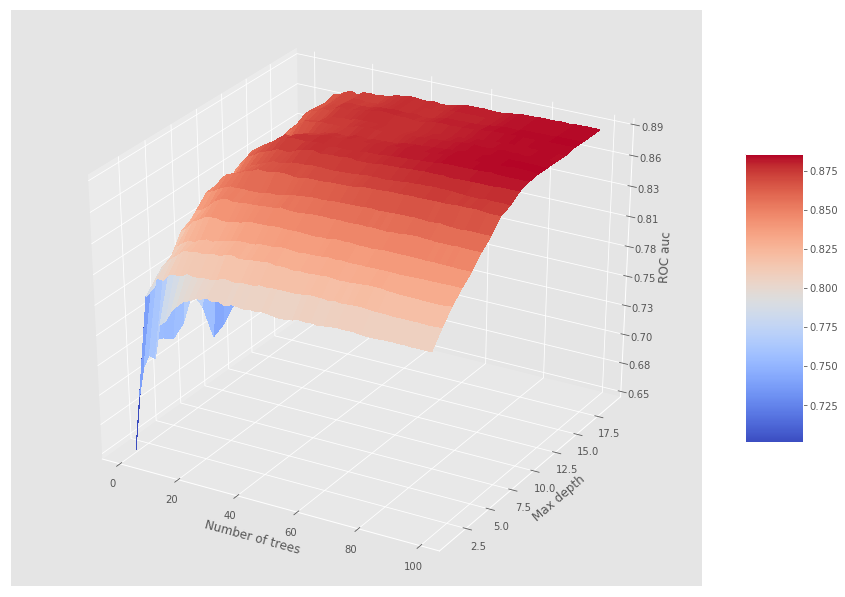

In [27]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

fig = plt.figure()
ax = Axes3D(fig)

#Приготовление данных
X = grid_search.cv_results_['param_n_estimators'].reshape(19, 50)
Y = grid_search.cv_results_['param_max_depth'].reshape(19, 50)
Z = grid_search.cv_results_['mean_test_score'].reshape(19, 50)
 
#Строим поверхность
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax.set_xlabel('Number of trees')
ax.set_ylabel('Max depth')
ax.set_zlabel('ROC auc')

#Шкала цветов
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

Кросс-валидация на обучающей выборке:

In [28]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

for metric in ('roc_auc', 'accuracy', 'precision', 'recall', 'f1'):
    print metric, '=', cross_val_score(grid_search.best_estimator_, X=df_train.iloc[:,0:-1], y=df_train.iloc[:,-1],
                     cv=5, scoring=metric).mean()

roc_auc = 0.885898264364
accuracy = 0.802894338426
precision = 0.809993872908
recall = 0.832499218017
f1 = 0.82003232514


Классификация на контрольной выборке (df_test) с лучшими параметрами классификатора:

In [29]:
test_classes = grid_search.best_estimator_.predict(df_test.iloc[:,0:-1]).reshape(1, -1)
test_scores = grid_search.best_estimator_.predict_proba(df_test.iloc[:,0:-1])
true_classes = df_test.iloc[:,-1].values.reshape(1, -1)

Метрики качества на контрольной выборке:

In [30]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

print 'ROC auc = ', roc_auc_score(true_classes[0], test_scores[:,1])
print 'Accuracy = ', accuracy_score(true_classes[0], test_classes[0])
print 'Precision = ', precision_score(true_classes[0], test_classes[0])
print 'Recall = ', recall_score(true_classes[0], test_classes[0])
print 'F1 = ', f1_score(true_classes[0], test_classes[0])

ROC auc =  0.889787466792
Accuracy =  0.796875
Precision =  0.774011299435
Recall =  0.845679012346
F1 =  0.808259587021


Получается, что на контрольной выборке метрики качества не сильно меньше, чем при кросс-валидации на обучающей, а roc auc и recall даже чуть больше, что хорошо - нет переобучения. Значения метрик 0,8 - 0,9 на тестовой выборке и малое отличие от метрик на обучающей выборке говорят о том, что это достаточно хорошая модель.